<a href="https://colab.research.google.com/github/Dotido10/Satellite_Imagery/blob/main/Copie_de_notebook_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'haitilandwatermask:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5425423%2F9005762%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240802%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240802T113051Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D36cb58b161539411a6a4649cb83667865455ddfcbad3687a5700d3e4bade52b974fb4bd00082abdc62fcc8198e69c4660d92f3131fd0496ae20049a07529498cbcf068a78c7fa910957253910a76fb2dddf43107ada769e5ab9fedcf4a2a9068861a3c51fa3014445326102059f61c65124c46de3848269eff07e1083bf8e969d7d109fe0e969b87e9528d5942c5f6e7752deb6ca961b3ebf42020458c88622e0540cab32f3f6edbb1af616b994da6352244220727d2d8512493e8b26634f92e9f49a9974c4733cc04f4e130c2bd7793c5ba72648a39b37d66f72464d16478bd5d60a6112cfb6b42fcb6fe294c8da8715f54125055fddd2226fe615cf22fdead,localfolium:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5430967%2F9013686%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240802%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240802T113051Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ed1e1801c82181d957a3d5356f763bddcbe963276031f8d41a65c8e3edb8543d978d88eff62d879c66736f5be270eb2fb462eab381bb253f19aac5e394c2b013c94643d564ad2d2b6054f1356bb669e1533bef195f3782733c4cc0162eb879e3ab2aff7f4797436e426e7a0ec7b157db4ea9f68a7e279f5291baf56e0136048525d440efbd53e891e53ed6dcc7b4ae23ab64dd4c24ef5412288b56b3ee683edf90328d77ca6bbd8545a410946c9a100db7ddbdf40c9d843aa639e2567307c25df23293e0bed6cf95e92e9e0c4526f4310d6d6f3cee50b7816d82418686dc3f85f49905d6c7d2c504a5f23d401eed237c7bec65447dbfe33ba4e14b709e1d380'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 343922262 bytes downloaded
Downloaded and uncompressed: haitilandwatermask
[==================================================] 2069 bytes downloaded
Downloaded and uncompressed: localfolium
Data source import complete.


# *1.Introduction*
For this work, we will use data from the Sentinel-2 instrument and a Random Forest algorithm to perform water classification.

The intent of this notebook is two-fold:

First, we will perform some training using the Random Forest algorithm.

Second, we will perform inference using the Random Forest algorithm, and will include some metrics to analyze its performance.

For this exercise we have downloaded our features data by using the Google Earth Engine from the copernicus platform.

We digitized manually our labeled data from the sentinel-2 image by using the QGIS software. Water extend frorm Lakes Azeui and Enriquillo were used.

# *2.Import Libraries*
In this section we import the Python libraries to use during the development of this notebook.

In [ ]:
pip install rasterio

In [ ]:
pip install optuna

In [ ]:
# Import module
import numpy as np
import pandas as pd
import joblib
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import rasterio as rio
from rasterio.plot import show
import os
import datetime
import optuna
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance

import sys
sys.path.append('/kaggle/input/localfolium/')

import folium
from folium import plugins
import folium_helper



In [ ]:
# controls random seed for reproducibility
RANDOM_STATE = 42

# *3.Data Loading and Exploratory Data Analysis*
In this section we have extracted a tabular dataset from Sentinel tiff files for the purpose of performing Exploratory Data Analysis (EDA).

In [ ]:
# Datasets
os.listdir('/kaggle/input/')

['localfolium', 'haitilandwatermask']

In [ ]:
# Dataset raster image X_train
ds = rio.open('/kaggle/input/haitilandwatermask/X_train.tif')
arr = ds.read()
arr = np.moveaxis(arr, 0, -1)
arr = np.where(np.isnan(arr), 0, arr)

nrow_train = arr.shape[0]
ncol_train = arr.shape[1]

X_train = np.reshape(arr, (arr.shape[0] * arr.shape[1], arr.shape[2]))
X_train.shape

(32947515, 4)

In [ ]:
ds.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 8751,
 'height': 3765,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -72.19885702608372,
        0.0, -8.983152841195215e-05, 18.692773252657886)}

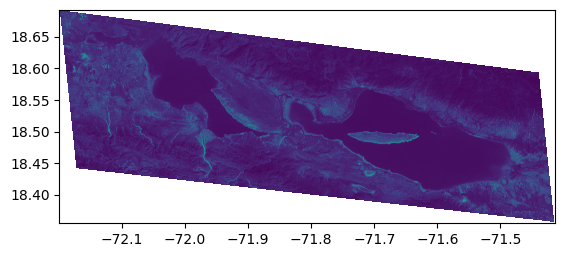

<Axes: >

In [ ]:
show(ds)

In [ ]:
# open raster image X_test
ds = rio.open('/kaggle/input/haitilandwatermask/X_test.tif')
arr = ds.read()
arr = np.moveaxis(arr, 0, -1)
arr = np.where(np.isnan(arr), 0, arr)

nrow_test = arr[0]
ncol_test = arr[1]

X_test = np.reshape(arr, (arr.shape[0] * arr.shape[1], arr.shape[2]))
X_test.shape

(4214412, 4)

In [ ]:
ds.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 2004,
 'height': 2103,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -70.32281538672851,
        0.0, -8.983152841195215e-05, 19.08363023277829)}

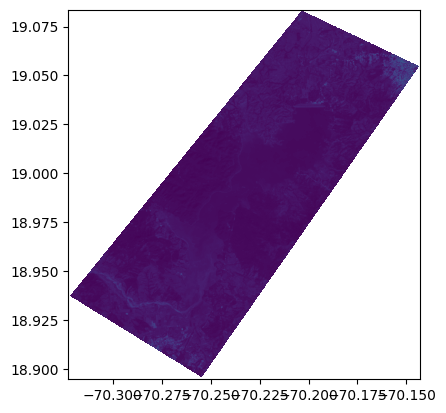

<Axes: >

In [ ]:
show(ds)

In [ ]:
# open raster image y_train
ds = rio.open('/kaggle/input/haitilandwatermask/y_train.tif')
arr=ds.read()
arr = np.moveaxis(arr, 0, -1)
arr = np.where(arr == np.nan, 0, arr)
y_train = arr.reshape(-1)
y_train.shape

(32947515,)

In [ ]:
ds.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 8751,
 'height': 3765,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -72.19885702608372,
        0.0, -8.983152841195215e-05, 18.692773252657886)}

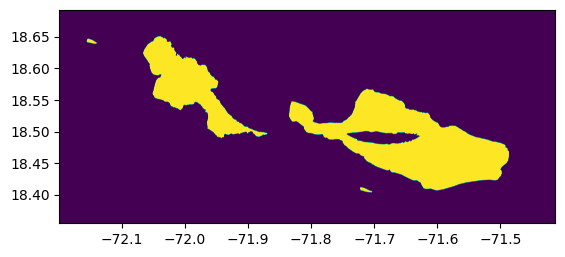

<Axes: >

In [ ]:
show(ds)

In [ ]:
# open raster image y_test
ds = rio.open('/kaggle/input/haitilandwatermask/y_test.tif')
arr = ds.read()
arr = np.moveaxis(arr, 0, -1)
arr = np.where(np.isnan(arr), 0, arr)
y_test = arr.reshape(-1)
y_test.shape

(4214412,)

In [ ]:
ds.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 2004,
 'height': 2103,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -70.32281538672851,
        0.0, -8.983152841195215e-05, 19.08363023277829)}

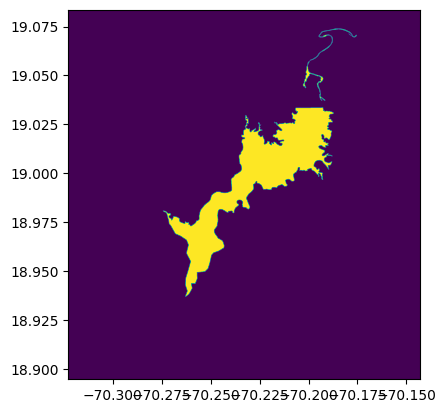

<Axes: >

In [ ]:
show(ds)

In [ ]:
X_train

array([[0.1039    , 0.0976    , 0.0842    , 0.2294    ],
       [0.1077    , 0.1012    , 0.0878    , 0.2441    ],
       [0.1091    , 0.1036    , 0.0878    , 0.2414    ],
       ...,
       [0.12244   , 0.12248334, 0.11885   , 0.2394    ],
       [0.1207    , 0.12163334, 0.1167    , 0.2515    ],
       [0.12353333, 0.1212    , 0.1214    , 0.2409    ]], dtype=float32)

In [ ]:
X_train.shape

(32947515, 4)

If we want to know if our data contains any no-data values

In [ ]:
np.count_nonzero(np.isnan(X_train))

0

In [ ]:
np.where(X_train == 0)

(array([       7,        7,        7, ..., 32947508, 32947508, 32947508]),
 array([0, 1, 2, ..., 1, 2, 3]))

In [ ]:
df_X_train = pd.DataFrame(X_train, columns=['B2', 'B3', 'B4', 'B8'])

In [ ]:
df_X_train

,B2,B3,B4,B8
0,0.103900,0.097600,0.08420,0.229400
1,0.107700,0.101200,0.08780,0.244100
2,0.109100,0.103600,0.08780,0.241400
3,0.103050,0.097800,0.08210,0.247900
4,0.106350,0.101400,0.08575,0.250650
...,...,...,...,...
32947510,0.123700,0.123650,0.12670,0.244475
32947511,0.121620,0.119750,0.12240,0.233650
32947512,0.122440,0.122483,0.11885,0.239400
32947513,0.120700,0.121633,0.11670,0.251500


Here we can then observe some statistics from the dataset

In [ ]:
df_X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
B2,32947515.0,0.078052,0.057806,0.0,0.0,0.089600,0.114800,0.5304
B3,32947515.0,0.074699,0.058789,0.0,0.0,0.081400,0.111633,0.5955
B4,32947515.0,0.066422,0.063203,0.0,0.0,0.055267,0.104500,0.7412
B8,32947515.0,0.144872,0.128411,0.0,0.0,0.195900,0.257700,0.8464


In [ ]:
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32947515 entries, 0 to 32947514
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   B2      float32
 1   B3      float32
 2   B4      float32
 3   B8      float32
dtypes: float32(4)
memory usage: 502.7 MB


In [ ]:
df_X_train[df_X_train.isnull().any(axis=1)]

,B2,B3,B4,B8


In [ ]:
df_train = df_X_train.copy()

In [ ]:
df_train = df_X_train.assign(y=y_train.tolist())

In [ ]:
df_train

,B2,B3,B4,B8,y
0,0.103900,0.097600,0.08420,0.229400,0
1,0.107700,0.101200,0.08780,0.244100,0
2,0.109100,0.103600,0.08780,0.241400,0
3,0.103050,0.097800,0.08210,0.247900,0
4,0.106350,0.101400,0.08575,0.250650,0
...,...,...,...,...,...
32947510,0.123700,0.123650,0.12670,0.244475,0
32947511,0.121620,0.119750,0.12240,0.233650,0
32947512,0.122440,0.122483,0.11885,0.239400,0
32947513,0.120700,0.121633,0.11670,0.251500,0


Distribution for each channel.

This section show where most of your data lives for each feature in the dataset, including the distribution of training labels.

array([[<Axes: title={'center': 'B2'}>, <Axes: title={'center': 'B3'}>],
       [<Axes: title={'center': 'B4'}>, <Axes: title={'center': 'B8'}>],
       [<Axes: title={'center': 'y'}>, <Axes: >]], dtype=object)

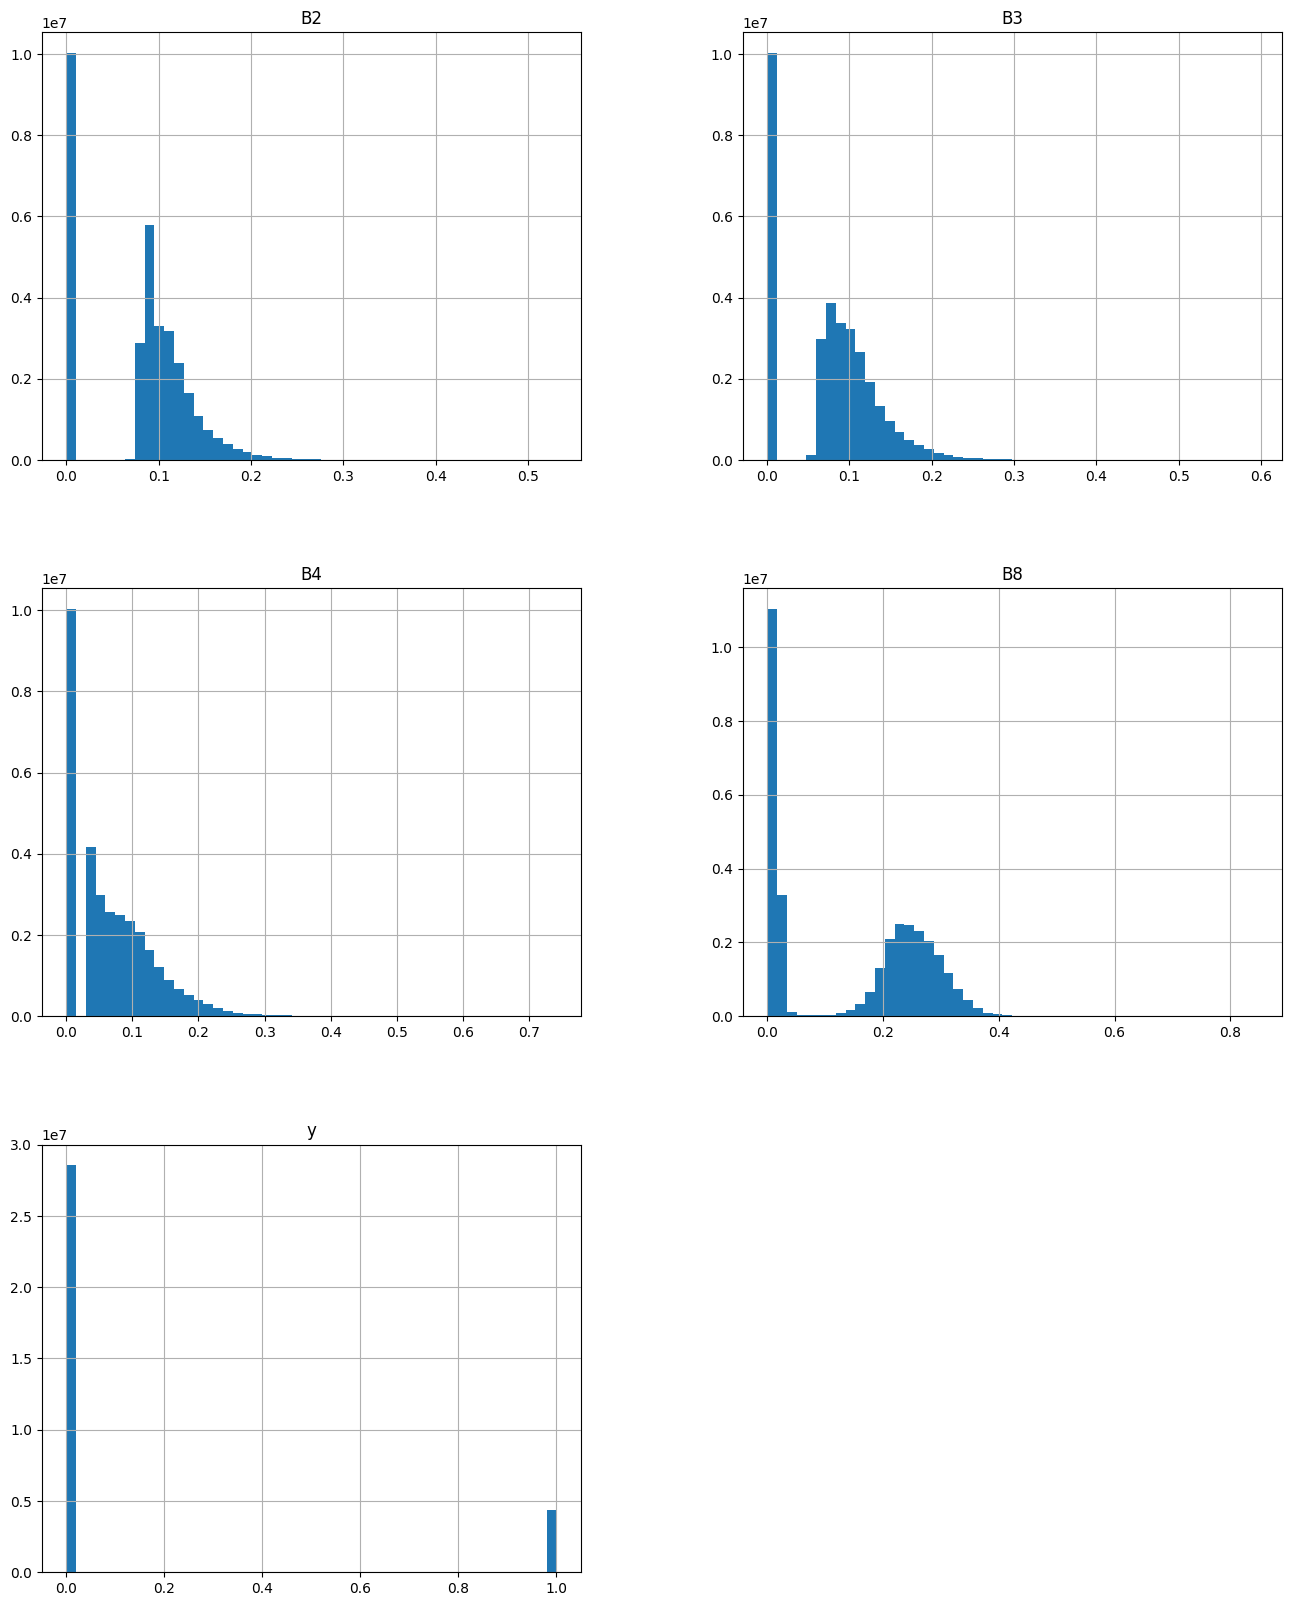

In [ ]:
df_train.hist(figsize=(16, 20), bins=50)

In [ ]:
df_y_train = pd.DataFrame(y_train, columns=['value'])

In [ ]:
df_y_train["value"].unique()

array([0, 1], dtype=uint8)

In [ ]:
df_y_test = pd.DataFrame(y_test, columns=['value'])

In [ ]:
df_y_test["value"].unique()

array([0, 1], dtype=uint8)

In [ ]:

df_y_train.value_counts(), df_y_test.value_counts()

(value
 0        28585005
 1         4362510
 Name: count, dtype: int64,
 value
 0        3960859
 1         253553
 Name: count, dtype: int64)

The distribution of the training features is 87% for not-water and 13% for water.

The distribution of the testing features is 94% for not-water and 6% for water.

Our datasets are imbalanced datasets, which means we need more water data for a better solution.

Correlation plots

The correlation step can help us find interesting features in our data by looking directly into relationships between our feature columns and our labels.

In [ ]:
# full correlation table
df_X_train.corr().style.background_gradient(cmap='viridis')

,B2,B3,B4,B8
B2,1.000000,0.991452,0.936678,0.818421
B3,0.991452,1.000000,0.967859,0.836755
B4,0.936678,0.967859,1.000000,0.807183
B8,0.818421,0.836755,0.807183,1.000000


In [ ]:
# correlation with dataset - target value
corr = df_train.corr()['y']
corr

,y
B2,0.067592
B3,-0.006564
B4,-0.154384
B8,-0.376064
y,1.000000


In [ ]:
nrow_test = arr.shape[0]
ncol_test = arr.shape[1]

# *4.Model definition and training*
We define our classifier, and perform the fit operation directly on the training dataset.

In [ ]:
hyperparameters = {'n_estimators': 100,
                   'criterion':'gini',
                   'max_depth':None,
                   'min_samples_split':2,
                   'min_samples_leaf':1,
                   'min_weight_fraction_leaf':0.0,
                   'max_features':'sqrt',
                   'max_leaf_nodes':None,
                   'min_impurity_decrease':0.0,
                   'bootstrap':True,
                   'oob_score':False,
                   'n_jobs':-1,
                   'random_state':42,
                   'verbose':3,
                   'warm_start':False,
                   'class_weight':None,
                   'ccp_alpha':0.0,
                   'max_samples':None
                  }

In [ ]:
rfc = RandomForestClassifier(**hyperparameters)

In [ ]:
# Fit model
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 33.8min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 110.9min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=3)

In [ ]:
# Make predictions
y_pred = rfc.predict(X_test)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   27.5s finished


In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
y_pred_reshaped = y_pred.reshape(nrow_test, ncol_test)
y_test_reshaped = y_test.reshape(nrow_test, ncol_test)
X_test_reshaped = X_test.reshape(nrow_test, ncol_test, 4)
print(y_pred_reshaped.shape, X_test_reshaped.shape)

(2103, 2004) (2103, 2004, 4)


# 5. *Visualization of the output*

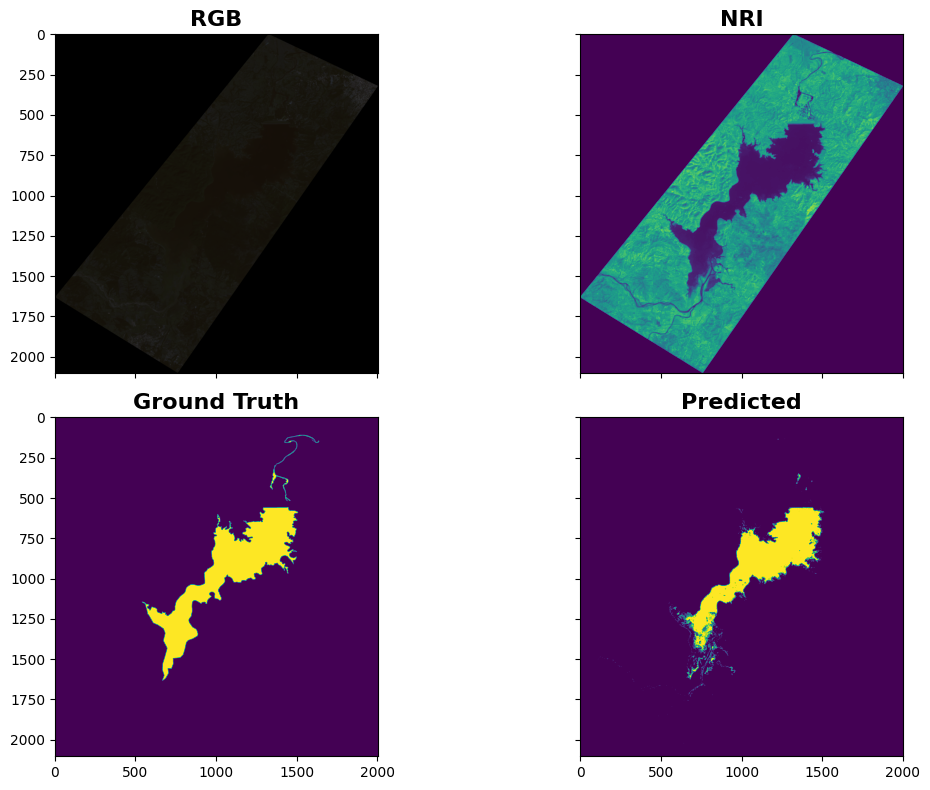

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.set_title("RGB", fontweight='bold', fontsize='16')
ax1.imshow(X_test_reshaped[:,:,:3])

ax2.set_title("NRI", fontweight='bold', fontsize='16')
ax2.imshow(X_test_reshaped[:,:,3])

ax3.set_title("Ground Truth", fontweight='bold', fontsize='16')
ax3.imshow(y_test_reshaped[:,:])

ax4.set_title("Predicted", fontweight='bold', fontsize='16')
ax4.imshow(y_pred_reshaped[:,:])

plt.tight_layout()

plt.show()

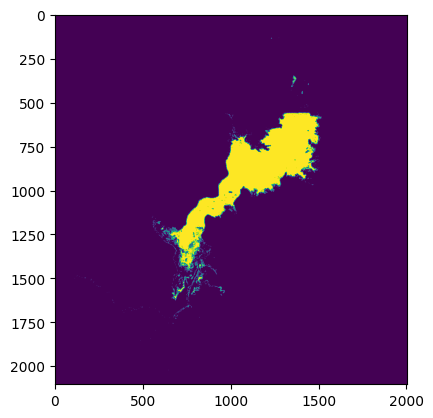

In [ ]:
#Visualising raster from array
rio.plot.show(y_pred_reshaped);

In [ ]:
y_pred_reshaped.dtype

dtype('uint8')

In [ ]:
# Output the predicted to GeoTiff
raster = rio.open('/kaggle/input/haitilandwatermask/X_test.tif')

with    rio.open(
        "./predicted.tif", "w",
        driver = "GTiff",
        crs = raster.crs,
        transform = raster.transform,
        dtype = rio.uint8,
        count = raster.count,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(y_pred_reshaped, indexes = 1)

In [ ]:
predictedPath = os.getcwd() + "/predicted.tif"


We can then proceed to visualize the output of our model in an interactive map.

But first, we need to fix the projection in order to properly display the map using the interactive visualization package called folium.

In [ ]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 10.31, 0.00,-7828300.00|
| 0.00,-10.31, 2164784.50|
| 0.00, 0.00, 1.00|
Width: 1945 Height: 2158


In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


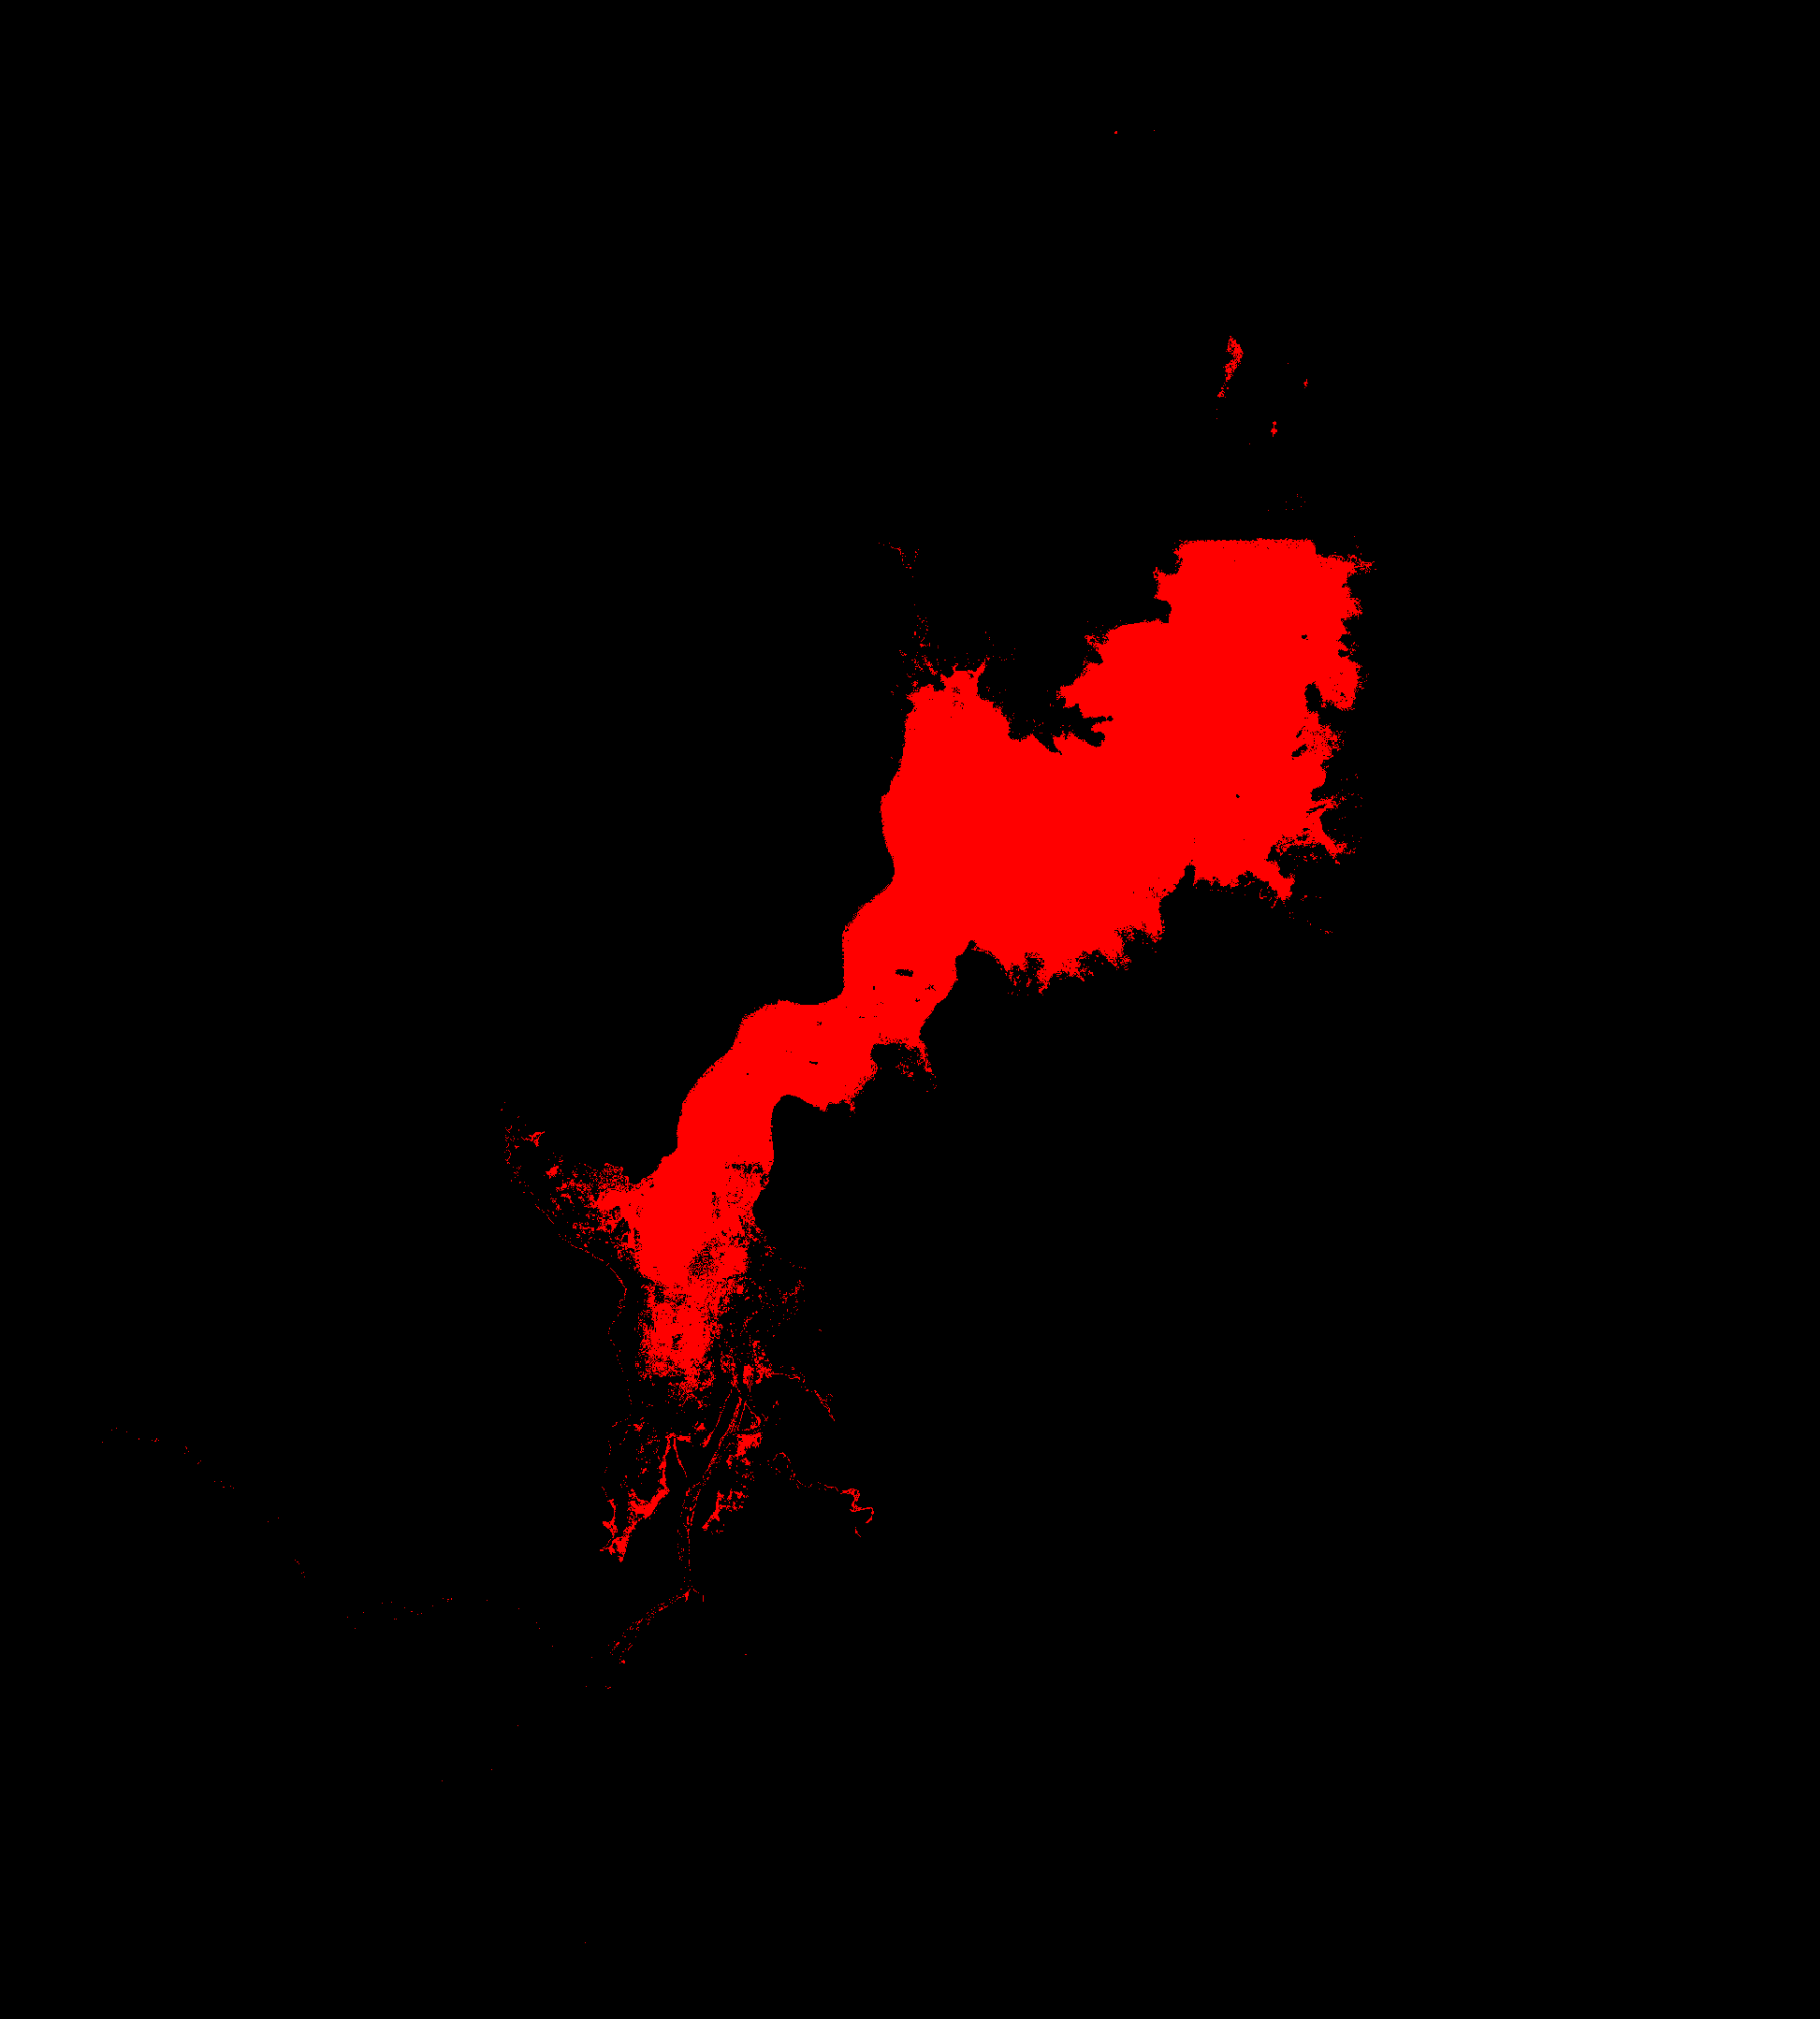

In [ ]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification RF predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())

 # *6.Get model metrics*

In [ ]:
# Score computation from the model output
score = rfc.score(X_test, y_test)
score = round(score, 3)
score

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   26.2s finished


0.987

In [ ]:
train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)
prediction_probs = rfc.predict_proba(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   27.1s finished


In [ ]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)


These are the probability that each test data point is water p=1 vs land p=0.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

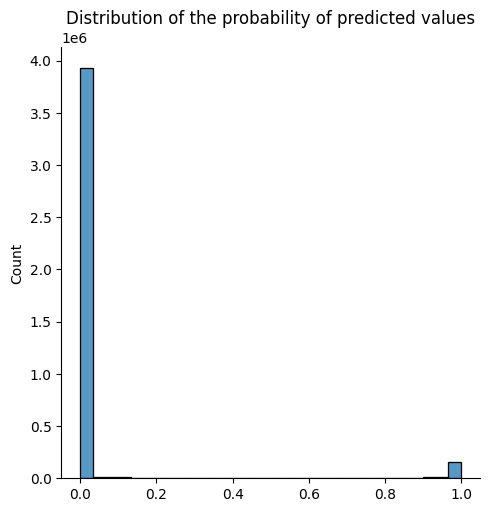

In [ ]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [ ]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

We can compute additional metrics to understand model performance related to producer and user accuracy.

In [ ]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   3960859
           1       0.96      0.81      0.88    253553

    accuracy                           0.99   4214412
   macro avg       0.98      0.90      0.94   4214412
weighted avg       0.99      0.99      0.99   4214412

Test Recall
-------------------------------------------------------
0.9980827391230034
Confusion Matrix
-------------------------------------------------------
[[3953265    7594]
 [  47722  205831]]


We can also look at Receiver Operating Characteristic (ROC) plots to understand the performance of the model across all samples between True Positive and False Positive rates.

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   27.1s finished


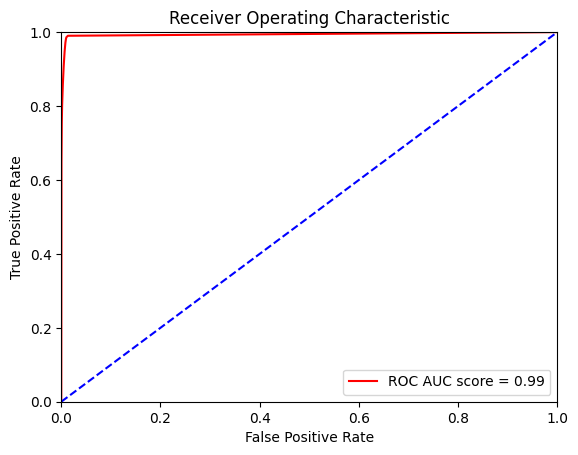

In [ ]:
clf = rfc

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Another important metric to understand model performance is to evaluate permutation importance, particularly focused on the importance of each feature in the training and inference of the model.

In [ ]:
%%time
permutation_importance_results = permutation_importance(rfc,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   27.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   26.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   26.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.1s
[Parallel(n_job

CPU times: user 29min 4s, sys: 3min 58s, total: 33min 2s
Wall time: 19min 51s


Text(0.5, 0, 'Permutation Importance')

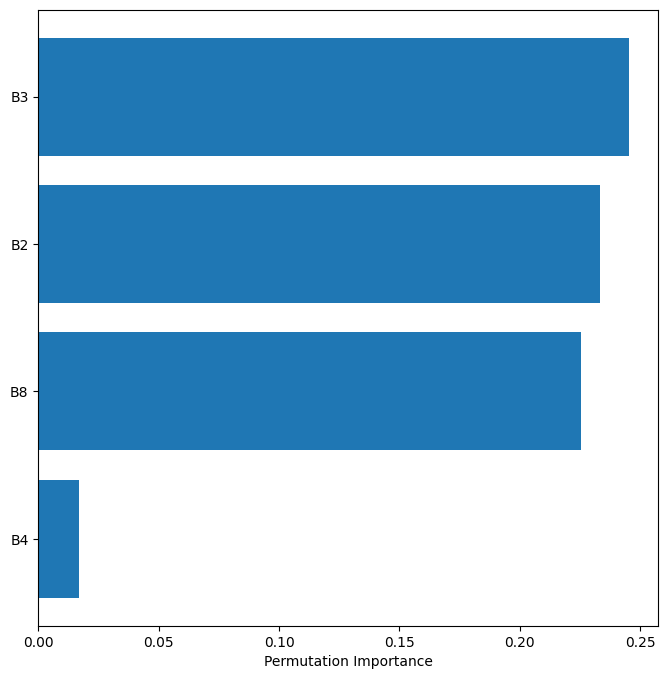

In [ ]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(df_X_train.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Note how the B1 band was the variable of most importance during the training and inference of the model.

**References :**

https://appliedsciences.nasa.gov/get-involved/training/english/arset-fundamentals-machine-learning-earth-science

https://www.youtube.com/watch?v=CXlGhiJWKGg&t=210s